In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
train_data.head()


/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv
Train shape: (891, 12)
Test shape: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


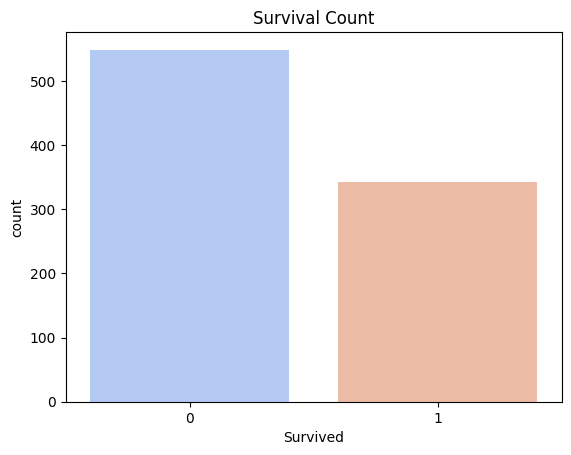

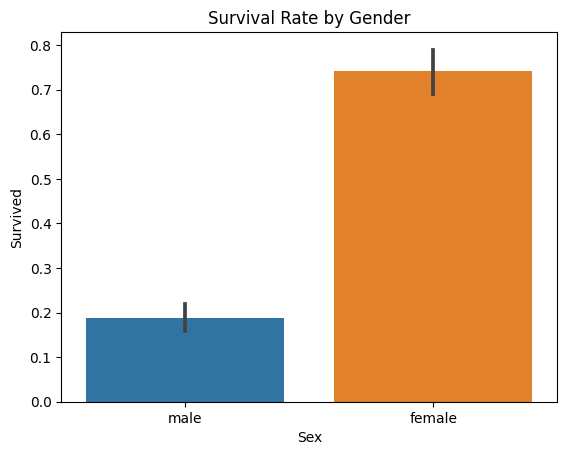

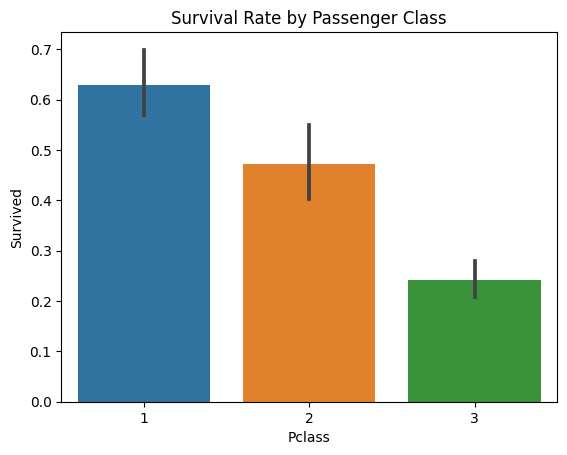

In [2]:
train_data.isnull().sum()

sns.countplot(x='Survived', data=train_data, palette='coolwarm')
plt.title('Survival Count')
plt.show()

sns.barplot(x='Sex', y='Survived', data=train_data)
plt.title('Survival Rate by Gender')
plt.show()

sns.barplot(x='Pclass', y='Survived', data=train_data)
plt.title('Survival Rate by Passenger Class')
plt.show()


In [4]:
train_data['Age'] = train_data['Age'].fillna(train_data['Age'].median())
test_data['Age'] = test_data['Age'].fillna(test_data['Age'].median())

train_data['Embarked'] = train_data['Embarked'].fillna(train_data['Embarked'].mode()[0])
test_data['Fare'] = test_data['Fare'].fillna(test_data['Fare'].median())

train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch'] + 1

train_data['IsAlone'] = (train_data['FamilySize'] == 1).astype(int)
test_data['IsAlone'] = (test_data['FamilySize'] == 1).astype(int)

train_data['Title'] = train_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_data['Title'] = test_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

for df in [train_data, test_data]:
    df['Title'] = df['Title'].replace(['Lady','Countess','Capt','Col','Don','Dr','Major',
                                       'Rev','Sir','Jonkheer','Dona'], 'Rare')
    df['Title'] = df['Title'].replace(['Mlle','Ms'], 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')

label = LabelEncoder()
for col in ['Sex', 'Embarked', 'Title']:
    train_data[col] = label.fit_transform(train_data[col])
    test_data[col] = label.transform(test_data[col])


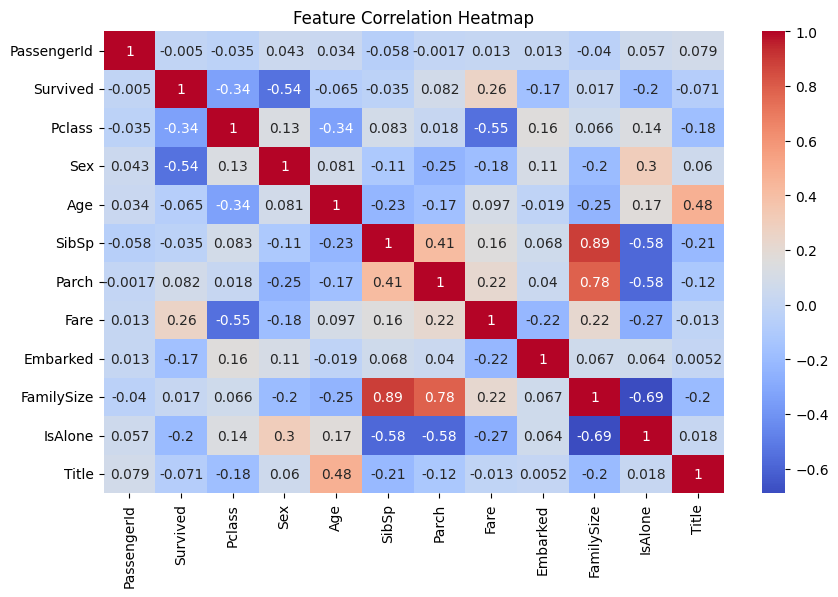

In [5]:
plt.figure(figsize=(10,6))
sns.heatmap(train_data.select_dtypes(include=['int64', 'float64']).corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


In [6]:
features = ['Pclass', 'Sex', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Title']
X = train_data[features]
y = train_data['Survived']
X_test = test_data[features]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    acc = accuracy_score(y_val, preds)
    results[name] = round(acc, 4)

comparison = pd.DataFrame.from_dict(results, orient='index', columns=['Validation Accuracy'])
comparison.sort_values(by='Validation Accuracy', ascending=False)


,Validation Accuracy
Logistic Regression,0.8101
Random Forest,0.8101
Gradient Boosting,0.7989


In [7]:
final_model = GradientBoostingClassifier(random_state=42)
final_model.fit(X, y)

predictions = final_model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("✅ Submission file created successfully!")


✅ Submission file created successfully!
